In [26]:
!pip install tensorflow_hub

     ------------------------------------ 100.6/100.6 kB 960.9 kB/s eta 0:00:00


In [1]:
# Importing necessary libraries

# Building deep learning models
import tensorflow as tf 
from tensorflow import keras 
# For accessing pre-trained models
import tensorflow_hub as hub 
# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2

import os
import numpy as np
import pathlib

#  DATA PREPARING

In [2]:
data_dir = "C:\\Users\\HP\\Downloads\\rice\\archive (12)\\Rice_Image_Dataset"
data_dir = pathlib.Path(data_dir)

data_dir

WindowsPath('C:/Users/HP/Downloads/rice/archive (12)/Rice_Image_Dataset')

#  Seperating the categories

In [3]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

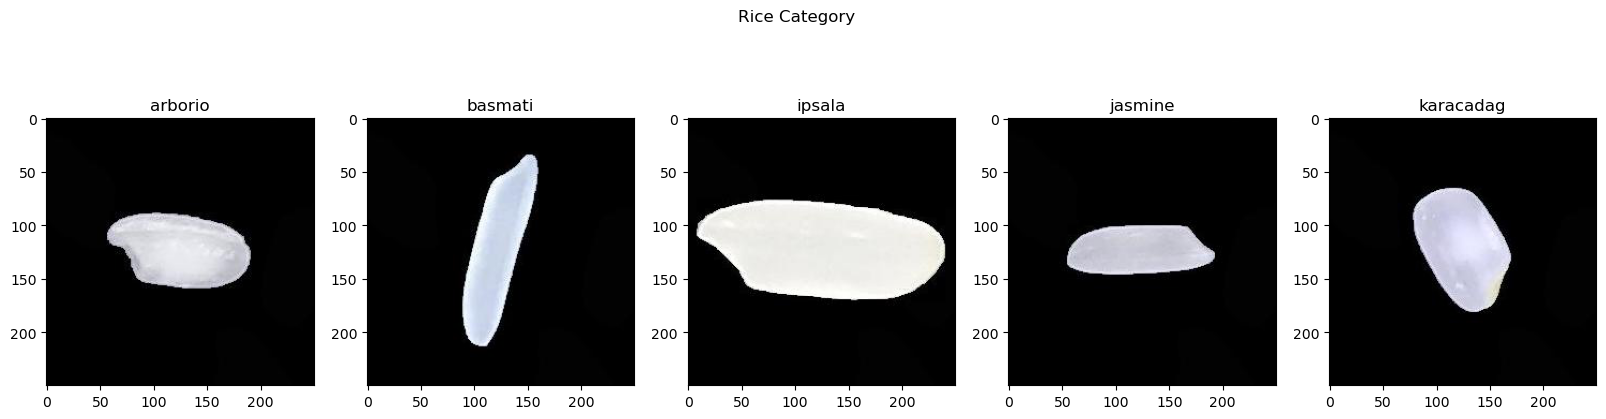

In [4]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category')
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')


ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

In [6]:
# Contains the images path
df_images = {
    'Arborio' : arborio,
    'Basmati' : basmati,
    'Ipsala' : ipsala,
    'Jasmine' : jasmine,
    'Karacadag': karacadag
}

# Contains numerical labels for the categories
df_labels = {
    'Arborio' : 0,
    'Basmati' : 1,
    'Ipsala' : 2,
    'Jasmine' : 3,
    'Karacadag': 4
}

In [7]:
image = cv2.imread(str(df_images['Arborio'][0])) # Converting it into numerical arrays
image.shape # Its currently 250 by 250 by 3

(250, 250, 3)

In [8]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])

In [9]:
# standardizing
X=np.array(X)
X=X/255
y=np.array(y)

In [10]:
# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

#  Creating the Model

In [11]:
mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' # MobileNetv4 link
mobile_net = hub.KerasLayer(
        mobile_net, input_shape=(224,224, 3), trainable=False) # Removing the last layer

In [12]:
num_label = 5 # number of labels

model = keras.Sequential([
    mobile_net,
    keras.layers.Dense(num_label)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


#  Training the Model

In [13]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
71/71 [==============================] - 183s 2s/step - loss: 0.5969 - acc: 0.8209 - val_loss: 0.2243 - val_acc: 0.9255
Epoch 2/10
71/71 [==============================] - 124s 2s/step - loss: 0.1517 - acc: 0.9711 - val_loss: 0.1406 - val_acc: 0.9681
Epoch 3/10
71/71 [==============================] - 105s 1s/step - loss: 0.1040 - acc: 0.9813 - val_loss: 0.1101 - val_acc: 0.9681
Epoch 4/10
71/71 [==============================] - 119s 2s/step - loss: 0.0824 - acc: 0.9831 - val_loss: 0.0862 - val_acc: 0.9734
Epoch 5/10
71/71 [==============================] - 99s 1s/step - loss: 0.0681 - acc: 0.9871 - val_loss: 0.0706 - val_acc: 0.9840
Epoch 6/10
71/71 [==============================] - 98s 1s/step - loss: 0.0587 - acc: 0.9889 - val_loss: 0.0609 - val_acc: 0.9947
Epoch 7/10
71/71 [==============================] - 104s 1s/step - loss: 0.0519 - acc: 0.9902 - val_loss: 0.0567 - val_acc: 0.9840
Epoch 8/10
71/71 [==============================] - 99s 1s/step - loss: 0.0473 - acc:


# Evaluate the Model

In [14]:
model.evaluate(X_test,y_test)

18/18 [==============================] - 35s 2s/step - loss: 0.0566 - acc: 0.9875


[0.05663314834237099, 0.9875444769859314]

In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

9/9 [==============================] - 68s 2s/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       129
           1       1.00      0.98      0.99       108
           2       1.00      1.00      1.00       110
           3       0.97      1.00      0.99       116
           4       0.98      0.98      0.98        99

    accuracy                           0.99       562
   macro avg       0.99      0.99      0.99       562
weighted avg       0.99      0.99      0.99       562



In [16]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas as pd

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()

loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()

# Visualizing the model

In [17]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas as pd

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()


In [18]:
loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()


In [19]:
# Prediction and Visualization
def decode_labels(pred):
    label_map = {
        0: 'Arborio',
        1: 'Basmati',
        2: 'Ipsala',
        3: 'Jasmine',
        4: 'Karacadag'
    }
    return [label_map[p] for p in pred]


1/1 [==============================] - 1s 672ms/step


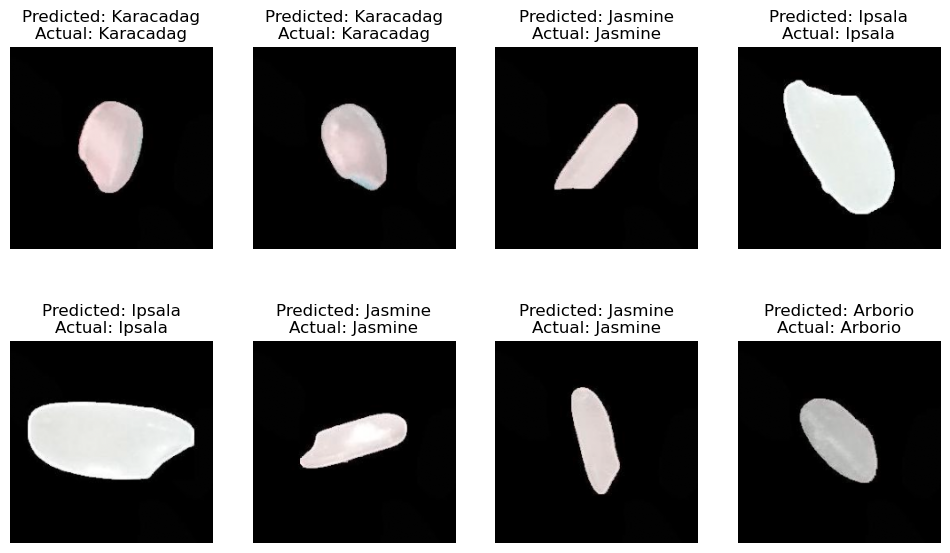

In [20]:
def predict(images):
    pred = model.predict(images)
    pred = np.argmax(pred, axis=-1)
    pred = decode_labels(pred)
    return pred

NUM_IMAGES = 8
pred = predict(X_test[:NUM_IMAGES])
labels = decode_labels(y_test[:NUM_IMAGES])
images = X_test[:NUM_IMAGES]

cols = 4
rows = 2
fig = plt.figure(figsize=(12, 7))

for x in range(NUM_IMAGES):
    fig.add_subplot(rows, cols, x+1)
    plt.axis('off')
    plt.title('Predicted: ' + str(pred[x]) + '\nActual: ' + str(labels[x]))
    plt.imshow(images[x])

plt.show()






